In [1]:
import env

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from acquire import acquire_zillow
from prepare import prepare_zillow, generate_scaled_splits, rfe, select_kbest
from explore import explore_bivariate_categorical, explore_bivariate_continuous, test_hypothesis_correlation, test_hypothesis_ttest, explore_multivariate, plot_distributions
from model import generate_baseline_model, generate_regression_model, apply_model_to_test_data
from utilities import nan_null_empty_check, explore_univariate, generate_xy_splits, plot_residuals, better_than_baseline

# Location matters, but square feet is king!

## Executive Summary
* The interplay between total square feet, bedrooms, and bathrooms was the largest driver of tax value
* Location was the second leading driver of tax value
* Age was the smallest factor for tax value
* The model has a lot of room for improvement:  explained variance score of 0.27

## Planning
The Agile Kanban methodology was used to map out the tasks for this project. The Kanban board used can be found [here](https://trello.com/b/PsLwYoee).

I wanted to test the following possibilities:
1. Does the tax value increase as the number of bathrooms increase?
2. Does the tax value increase as the number of bedrooms increase?
3. Does the tax value increase as the total square feet incrases?
4. Does the tax value decrease with as age increases?
5. Is there a difference between tax values based on the FIPS county?

#### [Data Dictionary](https://github.com/david-ryan-alviola/regression-project#data-dictionary)

## Acquisition
Data was obtained from the *zillow* database using this query:
> `SELECT bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, taxamount, fips
	FROM properties_2017
		JOIN predictions_2017 USING(parcelid)
	WHERE (transactiondate BETWEEN '2017-05-01' AND '2017-08-31')
		AND (unitcnt = 1 OR propertylandusetypeid IN (261, 279, 262, 263, 264, 266, 275))
		AND calculatedfinishedsquarefeet IS NOT NULL
		AND bathroomcnt IS NOT NULL
		AND bedroomcnt IS NOT NULL
		AND fips IS NOT NULL
		AND taxvaluedollarcnt IS NOT NULL
		AND taxamount IS NOT NULL
        AND yearbuilt IS NOT NULL`

Initially, using only `unitcnt = 1` did not provide adequate distribution of data points across the different FIPS county codes, so additional `propertylandusetypeid` values were used to bring in more data. Single unit properties were defined as "a property that can be purchased or rented as a single entity." These `propertylandusetypeid` values met that definition:
* 261 - single family residential 
* 262 - rural residence
* 263 - mobile home
* 264 - townhouse
* 266 - condominium
* 275 - manufactured, modular, prefabricated homes
* 279 - inferred single family residential

The acquisition was scripted with the `acquire_zillow` function.

In [2]:
zillow_df = acquire_zillow()

## Preparation
The resulting data frame was double-checked for missing values and none were found.

In [3]:
nan_null_empty_check(zillow_df)

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------


{'nan_positions': (array([], dtype=int64), array([], dtype=int64)),
 'empty_positions': (array([], dtype=int64), array([], dtype=int64))}

The selected features were all numerical values and the only apparent task from the information on the data frame was renaming the column names.

In [4]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39358 entries, 0 to 39357
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   39358 non-null  float64
 1   bedroomcnt                    39358 non-null  float64
 2   calculatedfinishedsquarefeet  39358 non-null  float64
 3   taxvaluedollarcnt             39358 non-null  float64
 4   taxamount                     39358 non-null  float64
 5   fips                          39358 non-null  float64
 6   yearbuilt                     39358 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


However, univariate exploration revealed that outliers were skewing the distributions of the features to the right and they would have to be removed. 1.5 * IQR was used to determine the lower and upper bounds for outliers.

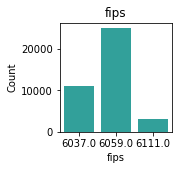

          fips  Count  Percent
6037.0  6059.0  25069    63.69
6059.0  6037.0  11080    28.15
6111.0  6111.0   3209     8.15
_________________________________________________________________


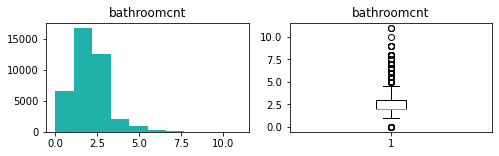

count    39358.000000
mean         2.298033
std          0.947233
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: bathroomcnt, dtype: float64


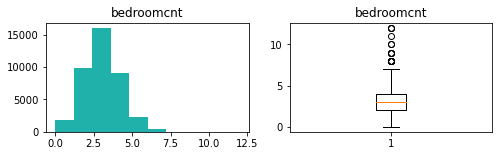

count    39358.000000
mean         3.027415
std          1.015386
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedroomcnt, dtype: float64


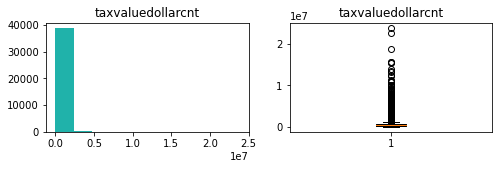

count    3.935800e+04
mean     4.969634e+05
std      6.244659e+05
min      1.000000e+03
25%      2.118865e+05
50%      3.670000e+05
75%      5.798970e+05
max      2.385837e+07
Name: taxvaluedollarcnt, dtype: float64


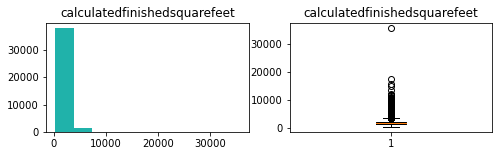

count    39358.000000
mean      1773.233523
std        945.063989
min        240.000000
25%       1180.000000
50%       1537.000000
75%       2094.000000
max      35640.000000
Name: calculatedfinishedsquarefeet, dtype: float64


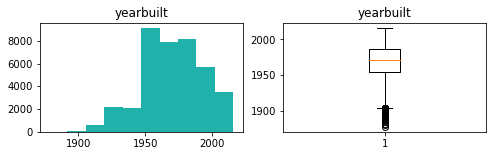

count    39358.000000
mean      1969.981046
std         23.099934
min       1878.000000
25%       1954.000000
50%       1971.000000
75%       1987.000000
max       2016.000000
Name: yearbuilt, dtype: float64


In [5]:
# There is a bug in this function causing the label for FIPS 6037 and 6059 to be switched. Use the index and disregard the fips column.
explore_univariate(zillow_df, ['fips'], quant_vars=['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt'])

These preparation steps were scripted into the `prepare_zillow` function that returns a dictionary containing the prepared data frame of the entire population and the train, validate, test samples.  To make `yearbuilt` more continuous, it was converted to `age`, which is the difference between the current year and `yearbuilt`, and then dropped. The `tax_rate` was also calculated by dividing `tax_amount` by `tax_value` and then dropping `tax_amount` to exclude it from the model.

In [6]:
prepped_data = prepare_zillow(zillow_df)

population = prepped_data['population']
train, validate, test = prepped_data['samples']

## Exploration

#### Univariate exploration
The removal of outliers made the bathroom and bedroom distributions more normal, however, the `tax_value` and `total_sqft` distributions remained right skewed, but to a lesser degree.

Key findings:
1. A majority of properties are in FIPS county 6037 (62%)
2. Most properties have 2 bathrooms.
3. Most properties have 3 bedrooms.
4. The mean tax value is 400_000 while the median is 364_000 indicating right skew.
5. The mean total square feet value is 1600 while the median is 1500 indicating slight right skew.
6. The mean age is 52 years.
7. The mean tax rate is .012.

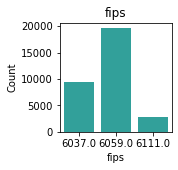

          fips  Count  Percent
6037.0  6059.0  19640    61.72
6059.0  6037.0   9386    29.50
6111.0  6111.0   2795     8.78
_________________________________________________________________


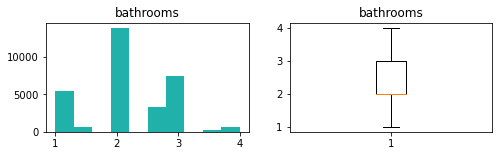

count    31821.000000
mean         2.157679
std          0.720057
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: bathrooms, dtype: float64


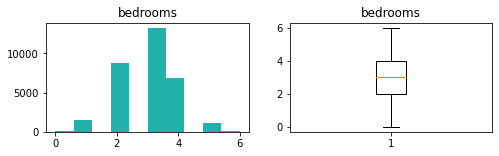

count    31821.000000
mean         2.911662
std          0.943146
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64


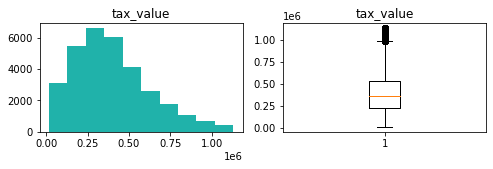

count    3.182100e+04
mean     4.003416e+05
std      2.284218e+05
min      1.543300e+04
25%      2.286530e+05
50%      3.640800e+05
75%      5.305160e+05
max      1.131770e+06
Name: tax_value, dtype: float64


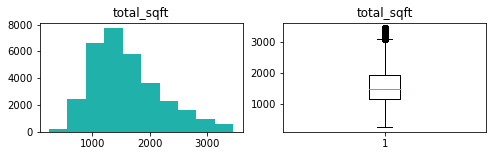

count    31821.000000
mean      1596.486220
std        601.821421
min        240.000000
25%       1154.000000
50%       1480.000000
75%       1935.000000
max       3464.000000
Name: total_sqft, dtype: float64


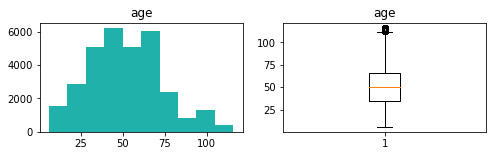

count    31821.000000
mean        51.610320
std         21.866932
min          6.000000
25%         35.000000
50%         50.000000
75%         66.000000
max        116.000000
Name: age, dtype: float64


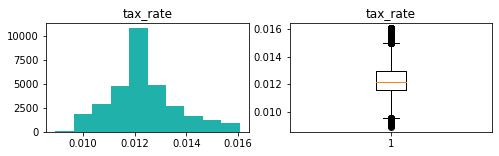

count    31821.000000
mean         0.012330
std          0.001293
min          0.008922
25%          0.011582
50%          0.012197
75%          0.012936
max          0.016068
Name: tax_rate, dtype: float64


In [7]:
# There is a bug in this function causing the label for FIPS 6037 and 6059 to be switched. Use the index and disregard the fips column.
explore_univariate(population, ['fips'], ['bathrooms', 'bedrooms', 'tax_value', 'total_sqft', 'age', 'tax_rate'])

#### Bivariate Exploration
When performing bivariate exploration, I found it easier to treat `fips`, `bathrooms`, and `bedrooms` as categorical values since the number of unique values were low and existed either whole or half number increments.

Key findings:
1. FIPS county 6037 properties have the highest tax value of 439_000
2. Properties with 3.5 bathrooms have the highest tax value of 720_000
3. Properties with 5 bedrooms have the highest tax value of 510_000
4. There appears to be a slight negative correlation between age and tax value
5. There appears to be a positive correlation between total square feet and tax value

Additional hypotheses to test:
1. Do FIPS 6037 properties have a higher tax value than the population?
2. Do properties with 3.5 bathrooms have a higher tax value than the population?
3. Do properties with 5 bedrooms have a higher tax value than the population?

In [8]:
print(f"bathrooms:  {train.bathrooms.unique()}")
print(f"bedrooms:  {train.bedrooms.unique()}")
print(f"fips:  {train.fips.unique()}")

bathrooms:  [2.5 2.  1.  3.  4.  1.5 3.5]
bedrooms:  [2. 3. 4. 1. 5. 6. 0.]
fips:  [6059. 6037. 6111.]


fips vs tax_value
-------------------------------


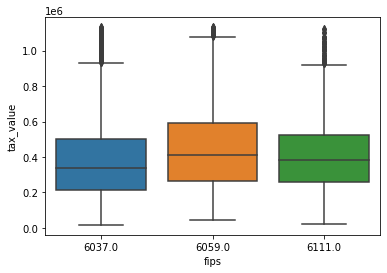

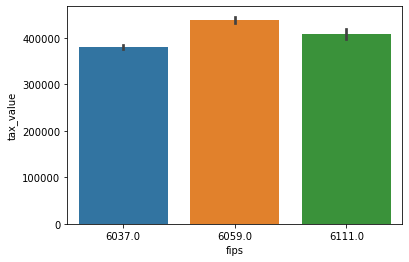

-------------------------------
Mean tax_value by fips:  
fips
6037.0    381151.942893
6059.0    438948.900612
6111.0    407447.896463
Name: tax_value, dtype: float64

bathrooms vs tax_value
-------------------------------


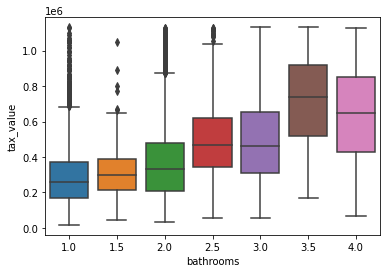

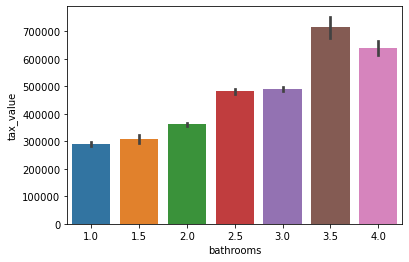

-------------------------------
Mean tax_value by bathrooms:  
bathrooms
1.0    289657.251033
1.5    307580.249357
2.0    362126.140255
2.5    482353.011860
3.0    491695.722912
3.5    715454.095808
4.0    639163.664935
Name: tax_value, dtype: float64

bedrooms vs tax_value
-------------------------------


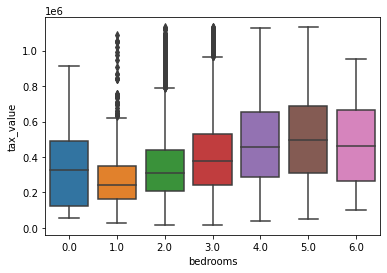

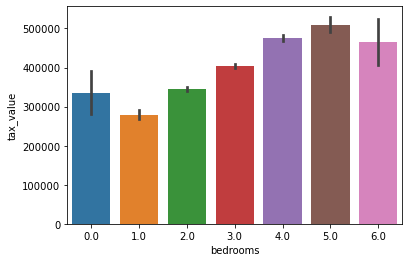

-------------------------------
Mean tax_value by bedrooms:  
bedrooms
0.0    334232.377049
1.0    279523.075775
2.0    346192.595966
3.0    403021.167998
4.0    476237.107973
5.0    509876.355140
6.0    465827.079365
Name: tax_value, dtype: float64



In [9]:
explore_bivariate_categorical('tax_value', ['fips', 'bathrooms', 'bedrooms'], train)

age vs tax_value
-------------------------------


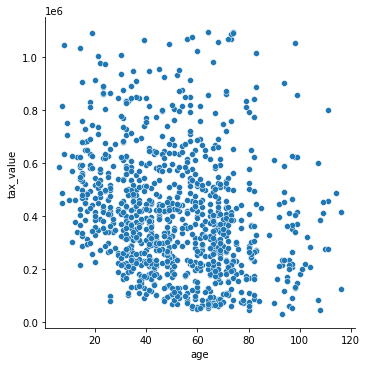

-------------------------------
Correlation between age and tax_value:  -0.2249784529567052
P value:  6.109421285066745e-13

total_sqft vs tax_value
-------------------------------


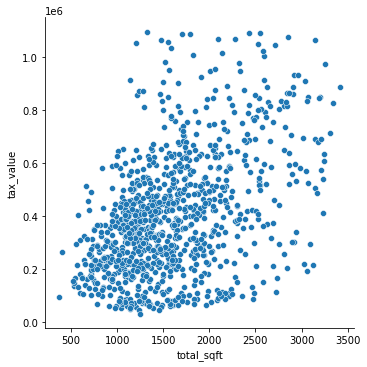

-------------------------------
Correlation between total_sqft and tax_value:  0.4591511335642381
P value:  2.6892033749793684e-53



In [10]:
explore_bivariate_continuous('tax_value', ['age', 'total_sqft'], train.sample(1000))

#### Hypothesis testing
I used an alpha of .05 to test my hypotheses:

In [11]:
alpha = .05

1. Is there a positive correlation between number of bathrooms and tax value?

In [12]:
null_hyp = "There is no correlation between bathrooms and tax value"
alt_hyp = "There is a correlation between bathrooms and tax value"

test_hypothesis_correlation('bathrooms', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.3686470641378871, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between bathrooms and tax value
Correlation direction:  positive
------------------------------------------


2. Is there a positive correlation between number of bedrooms and tax value?

In [13]:
null_hyp = "There is no correlation between bedrooms and tax value"
alt_hyp = "There is a correlation between bedrooms and tax value"

test_hypothesis_correlation('bedrooms', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.24384747553186353, p:  1.6363649512191054e-239, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between bedrooms and tax value
Correlation direction:  positive
------------------------------------------


3. Is there a positive correlation between total square feet and tax value?

In [14]:
null_hyp = "There is no correlation between total square feet and tax value"
alt_hyp = "There is a correlation between total square feet and tax value"

test_hypothesis_correlation('total_sqft', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.46934291789995974, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between total square feet and tax value
Correlation direction:  positive
------------------------------------------


4. Is there a negative correlation between age and tax value?

In [15]:
null_hyp = "There is no correlation between age and tax value"
alt_hyp = "There is a correlation between age and tax value"

test_hypothesis_correlation('age', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  -0.19584372329114047, p:  1.4862653452984842e-153, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between age and tax value
Correlation direction:  negative
------------------------------------------


5. Do FIPS 6059 properties have a higher tax value than the population?

In [16]:
null_hyp = "The tax value for FIPS 6059 properties is not higher than the mean tax value"
alt_hyp = "The tax value for FIPS 6059 properties is higher than the mean tax value"
fips_6059 = train[train.fips_6059 == 1]

test_hypothesis_ttest('tax_value', fips_6059, train, null_hyp, alt_hyp)

------------------------------------------
t:  11.922496186588239, p:  2.3643582662014837e-32, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for FIPS 6059 properties is higher than the mean tax value
------------------------------------------


6. Do properties with 3.5 bathrooms have a higher tax value than the population?

In [17]:
null_hyp = "The tax value for 3.5 bathrooms is not higher than the mean tax value"
alt_hyp = "The tax value for 3.5 bathrooms is higher than the mean tax value"
bath_35 = train[train.bathrooms == 3.5] 

test_hypothesis_ttest('tax_value', bath_35, train, null_hyp, alt_hyp)

------------------------------------------
t:  16.23715782652534, p:  4.135237540554219e-36, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for 3.5 bathrooms is higher than the mean tax value
------------------------------------------


7. Do properties with 5 bedrooms have a higher tax value than the population?

In [18]:
null_hyp = "The tax value for 5 bedrooms is not higher than the mean tax value"
alt_hyp = "The tax value for 5 bedrooms is higher than the mean tax value"
bedrooms_5 = train[train.bedrooms == 5] 

test_hypothesis_ttest('tax_value', bedrooms_5, train, null_hyp, alt_hyp)

------------------------------------------
t:  10.551947153524317, p:  4.130574771479273e-24, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for 5 bedrooms is higher than the mean tax value
------------------------------------------


#### Multivariate exploration
Since all null hypotheses were rejected, I peformed multivariate exploration with the continuous features against the tax value and used each of the categorical variables as the hue.

Key findings:
1. There is a large cluster of properties in the 1000 - 2000 square foot range that have tax values ranging from 100_000 - 400_000
    * Most of these properties appear to be in FIPS counties 6037 and 6059
    * Most of these properties appear to have 2 - 3 bedrooms
    * Most of these properties appear to have 2 bathrooms
2. There is a large cluster of properties in the 35 - 70 age range that have tax values ranging from 100_000 - 400_000
    * Many of the older homes are in FIPS county 6037
    * There is a wide distribution of number of rooms across the age values
    * Many older homes tend to have only 1 bathroom while younger homes tend to have more bathrooms

total_sqft vs tax_value
-------------------------------


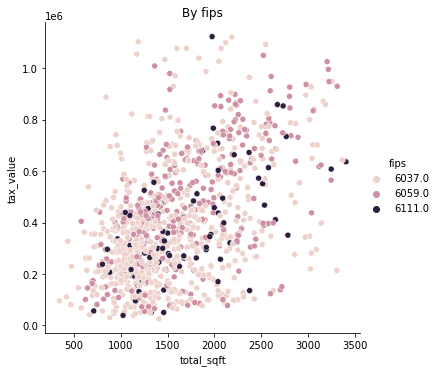

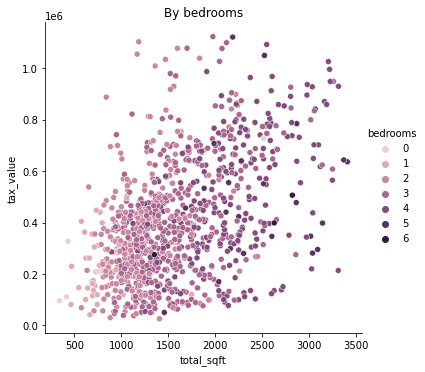

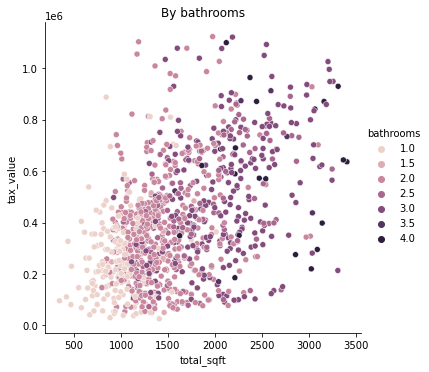


age vs tax_value
-------------------------------


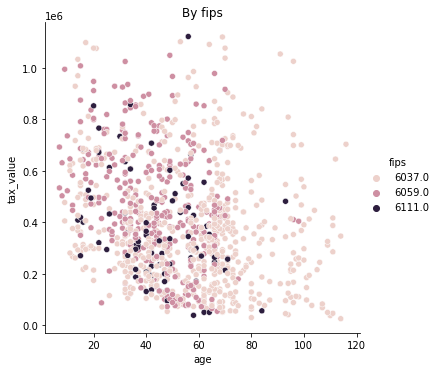

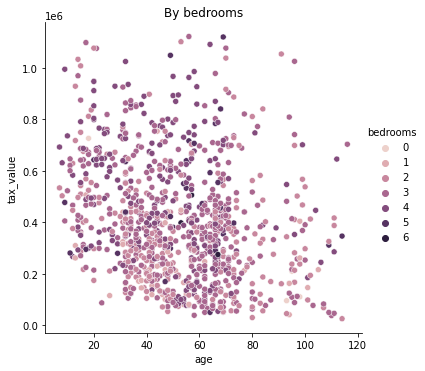

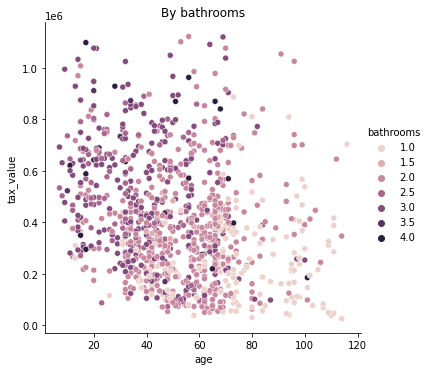

In [19]:
explore_multivariate(['total_sqft', 'age'], ['fips', 'bedrooms', 'bathrooms'], 'tax_value', train.sample(1000))

## Modeling and Evaluation
I selected `total_sqft`, `bathrooms`, `bedrooms`, the encoded `fips` values, and `age` as features for my model. RFE and KBest selectors chose `total_sqft` as the most important feature if only 1 was chosen, but ranked all 7 the same way when the number of features was increased to 7. The number of `bathrooms` and `bedrooms` probably rank higher with more features since the `total_sqft` would be affected by these features. The `age` only had a small negative correlation value of -0.2 which is probably why it ranked last.

In [20]:
splits = generate_xy_splits(train, validate, test, 'tax_value', drop_columns=['fips', 'tax_rate'])

In [21]:
X_train_scaled, X_validate_scaled, X_test_scaled = generate_scaled_splits(splits['X_train'], splits['X_validate'], splits['X_test'], StandardScaler())

In [22]:
rfe(X_train_scaled, splits['y_train'].tax_value, LinearRegression(), 1)

          Var  Rank
2  total_sqft     1
4   fips_6059     2
5   fips_6111     3
3   fips_6037     4
1    bedrooms     5
0   bathrooms     6
6         age     7


['total_sqft']

In [23]:
select_kbest(X_train_scaled, splits['y_train'].tax_value, 1)

['total_sqft']

In [24]:
select_kbest(X_train_scaled, splits['y_train'].tax_value, 7)

['bathrooms',
 'bedrooms',
 'total_sqft',
 'fips_6037',
 'fips_6059',
 'fips_6111',
 'age']

In [25]:
rfe(X_train_scaled, splits['y_train'].tax_value, LinearRegression(), 7)

          Var  Rank
0   bathrooms     1
1    bedrooms     1
2  total_sqft     1
3   fips_6037     1
4   fips_6059     1
5   fips_6111     1
6         age     1


['bathrooms',
 'bedrooms',
 'total_sqft',
 'fips_6037',
 'fips_6059',
 'fips_6111',
 'age']

#### Baseline model

Baseline models using the mean and median were compared and the mean model was selected since it performed better with a lower RMSE and slightly higher R-squared and explained variance score.

In [26]:
y_train = splits['y_train']
y_validate = splits['y_validate']
y_test = splits['y_test']

In [27]:
generate_baseline_model(y_train.tax_value.mean(), 'tax_value_pred_mean', 'tax_value', y_train, y_validate) 

RMSE using tax_value_pred_mean
Train/In-Sample:  228309.0621 
Validate/Out-of-Sample:  227410.1297
--------------------------------------------------
Train
Explained variance:  0.0
R-squared value:  0.0
--------------------------------------------------
Validate
Explained variance:  -0.0
R-squared value:  -0.0


In [28]:
generate_baseline_model(y_train.tax_value.median(), 'tax_value_pred_median', 'tax_value', y_train, y_validate) 

RMSE using tax_value_pred_median
Train/In-Sample:  231182.7793 
Validate/Out-of-Sample:  230383.3077
--------------------------------------------------
Train
Explained variance:  0.0
R-squared value:  -0.0253
--------------------------------------------------
Validate
Explained variance:  0.0
R-squared value:  -0.0263


#### Model selection
Four regression models were generated:
1. Ordinary least squares
2. LASSO + LARS
3. Generalized linear model
4. Polynomial model

The polynomial model with a degree of 2 was selected as the best model:
1. Lowest RMSE values
2. Lowest difference between train RMSE and validate RMSE
3. Highest train and validate R-squared and explained variance scores

In [29]:
ols = generate_regression_model(LinearRegression(normalize=True), X_train_scaled, X_validate_scaled, y_train, y_validate, 'tax_value_pred_lm', 'tax_value')

RMSE using tax_value_pred_lm
Train/In-Sample:  198949.1982 
Validate/Out-of-Sample:  199013.6775
--------------------------------------------------
Train
Explained variance:  0.2407
R-squared value:  0.2407
--------------------------------------------------
Validate
Explained variance:  0.2342
R-squared value:  0.2341


In [30]:
lars = generate_regression_model(LassoLars(alpha=1.0), X_train_scaled, X_validate_scaled, y_train, y_validate, 'tax_value_pred_lars', 'tax_value')

RMSE using tax_value_pred_lars
Train/In-Sample:  198949.5601 
Validate/Out-of-Sample:  199013.6908
--------------------------------------------------
Train
Explained variance:  0.2407
R-squared value:  0.2407
--------------------------------------------------
Validate
Explained variance:  0.2342
R-squared value:  0.2341


In [31]:
glm = generate_regression_model(TweedieRegressor(power=1, alpha=0), X_train_scaled, X_validate_scaled, y_train, y_validate, 'tax_value_pred_glm', 'tax_value')

RMSE using tax_value_pred_glm
Train/In-Sample:  199199.3905 
Validate/Out-of-Sample:  199260.2143
--------------------------------------------------
Train
Explained variance:  0.2387
R-squared value:  0.2387
--------------------------------------------------
Validate
Explained variance:  0.2322
R-squared value:  0.2322


In [32]:
pf = PolynomialFeatures(degree=2)
poly = LinearRegression(normalize=True)

X_train_degree2 = pf.fit_transform(X_train_scaled)
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

poly = generate_regression_model(poly, X_train_degree2, X_validate_degree2, y_train, y_validate, 'tax_value_pred_poly2', 'tax_value')

RMSE using tax_value_pred_poly2
Train/In-Sample:  194795.2645 
Validate/Out-of-Sample:  194931.6918
--------------------------------------------------
Train
Explained variance:  0.272
R-squared value:  0.272
--------------------------------------------------
Validate
Explained variance:  0.2652
R-squared value:  0.2652


#### Testing
The polynomial model was applied to the test data and had an RMSE of 197_000. The R-squared and explained variance scores were similar at 0.27. The polynomial model did perform better than the mean baseline model, but the residual plot shows a clear correlation between the target and difference between the prediction and target, meaning the model does not fully capture the factors that affect tax value.

In [33]:
apply_model_to_test_data(poly, X_test_degree2, y_test, 'tax_value_pred_poly2', 'tax_value')

RMSE for tax_value_pred_poly2 model
Out-of-Sample Performance: 196714.80036300028
Explained variance:  0.2654
R-squared value:  0.2653


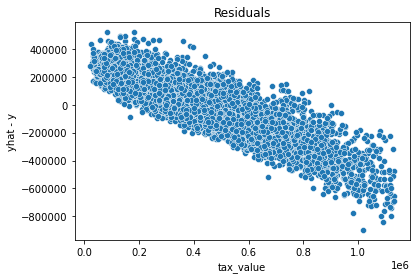

In [34]:
plot_residuals(y_test.tax_value, y_test.tax_value_pred_poly2)

In [35]:
better_than_baseline(y_test.tax_value, y_test.tax_value_pred_poly2)

----------------------------------------------
             model
sse   2.955268e+14
ess   1.024152e+14
tss   3.979420e+14
mse   3.869671e+10
rmse  1.967148e+05
----------------------------------------------
          baseline
sse   4.022683e+14
mse   5.267361e+10
rmse  2.295073e+05
----------------------------------------------
The MODEL performs better than the baseline with an SSE value of 295526794751327.0 and delta of -106741553421030.5


True

## Delivery

#### Tax rate distribution
The FIPS county 6037 (Los Angeles County) had the highest mean tax rate of 0.0127 and counties 6059 (Orange County) and 6111 (Venutra County) followed with mean tax rates of 0.0117 and 0.0114 respectively. FIPS county 6037 had a nearly normal distribution of tax rates while both counties 6059 and 6111 were skewed to the right. All properties were located in California.

fips vs tax_rate
-------------------------------


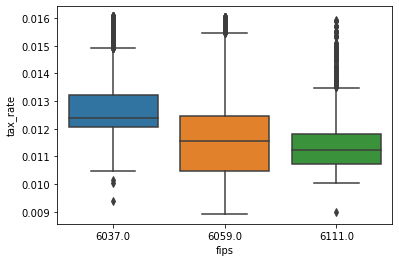

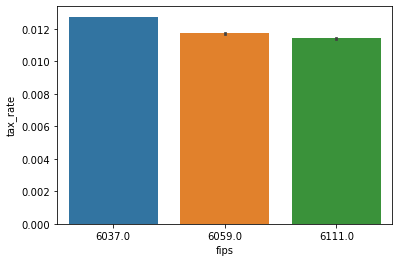

-------------------------------
Mean tax_rate by fips:  
fips
6037.0    0.012740
6059.0    0.011744
6111.0    0.011426
Name: tax_rate, dtype: float64



In [36]:
explore_bivariate_categorical('tax_rate', ['fips'], population)

In [37]:
county_6037 = population[population.fips == 6037]
county_6059 = population[population.fips == 6059]
county_6111 = population[population.fips == 6111]

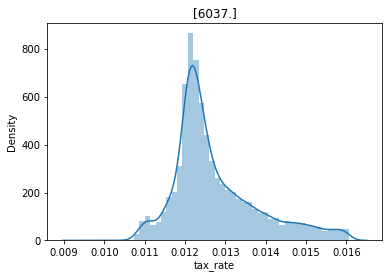


count    19640.000000
mean         0.012740
std          0.001062
min          0.009401
25%          0.012077
50%          0.012404
75%          0.013218
max          0.016068
Name: tax_rate, dtype: float64
------------------------


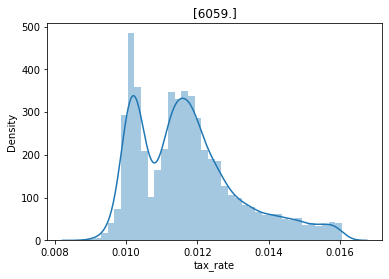


count    9386.000000
mean        0.011744
std         0.001456
min         0.008922
25%         0.010469
50%         0.011563
75%         0.012468
max         0.016056
Name: tax_rate, dtype: float64
------------------------


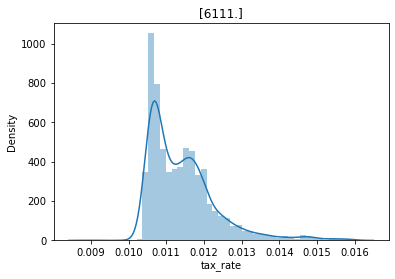


count    2795.000000
mean        0.011426
std         0.000909
min         0.008977
25%         0.010713
50%         0.011233
75%         0.011823
max         0.015934
Name: tax_rate, dtype: float64
------------------------


In [38]:
plot_distributions([county_6037, county_6059, county_6111], 'tax_rate', 'fips')

#### Key Takeaways
1. Square footage is the main driver for property tax value
    * Highly connected to bedrooms and bathrooms
2. Location matters
    * FIPS county ranked ahead of age in both feature selectors
3. Age seems to be a weak driver for property tax value
    * Low negative correlation
4. Model needs improvement
    * Residual plot shows correlation and low R-squared and explained variance scores
    
#### Recommendations
1. Add more features relating to square footage of property
2. Add latitude and longitude to model
3. Experiment with more regression models
4. Find ways to impute values for columns with too many missing values

#### Export
The prepared population is exported if you desire to visualize the data outside of this notebook.

In [39]:
population.to_csv("prepped_zillow.csv", index=False)